# Estudo de rotina do repositório 
## <font color = 'turquoise'> *Hyperspectral Analysis: Fungus and R. Microplus* em python

  Autor: Adriel Lenner Vinhal Mori

  Link para o repositório Git
  - [Git - ht4m](https://github.com/dvlucena/ht4m)
  - [Git - Adriel Mori](https://github.com/adrielmori)
  - [Git Bactérias - Ricardo](https://github.com/artsousa/HyperSI)

Visualização das amostras e processos:
  - [Ht4m-master_Adriel](https://colab.research.google.com/drive/1UXdp-8a-LMFlnS2XxtHMPqiJEFaW3cYO?usp=sharing)

Bibliografia e materiais
  - [Dimensionality Reduction on HSI](https://https://colab.research.google.com/drive/1Lstx55MxHT8bpXlgnaXYloVCmagE_xC7?usp=sharing#scrollTo=xjpDyNm3fKMt)

  - [Hyperspectral Image Analysis — Classification](https://towardsdatascience.com/hyperspectral-image-analysis-classification-c41f69ac447f)

In [3]:
import scipy.io
import numpy as np
import pandas as pdy

import h5py
import json

import os
import sys
import glob
# import earthpy as et
import spectral as sp
# import earthpy.spatial as es
# import earthpy.plot as ep
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from random import sample
from IPython.core.pylabtools import figsize

from mpl_toolkits import mplot3d
import numpy as np
from joblib import dump, load
import numpy.matlib
import pandas as pd
from mpl_toolkits.mplot3d import axes3d
from sklearn.cluster import KMeans
import pickle
# from spectral import *

from math import factorial
from sklearn.decomposition import PCA
from scipy.signal import savgol_filter
from sklearn.preprocessing import MinMaxScaler

import pprint
import seaborn as sn

import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# import cv2

sp.settings.envi_support_nonlowercase_params = True

%matplotlib inline

In [4]:
import sample as Sample
# import pipeline
# import utils
import __init__
# import hsiroutine

In [37]:
#Create a matrix of indices, according to the idx and rmv of the sample
def rev_idx_array(idx, rmv, shape=None, tfill=None):
    if shape is None:
        out = np.zeros(idx.shape[0] + rmv.shape[0])
    else:
        out = np.zeros(shape)

    out[rmv] = 0

    if tfill is not None:
        for i, row in enumerate(idx):
            out[row] = tfill[i]
    else:
        out[idx] = 1

    return out.astype(int)

#
def sum_idx_array(idx):
      ind_r = []
      for i, (j, ind) in enumerate(zip(idx, np.arange(idx.shape[0]))):
          if j != ind:
              ind_r.append(i)

      return np.delete(idx, ind_r), np.array(ind_r)
#
#Retorna o rotulo de cada pixel ao seu correpondente clustercluster
#É executado empregando as classes com os algoritmos PCA e K-means

def hsiRemoveBackground(key, X = None, PCS = None): 
    if 'Fungo' in key:
      aux_cube=hsi2matrix(X)
    else: 
      aux_cube=hsi2matrix(X)[:,100:220]

    scores = PCA(n_components=PCS).fit_transform(aux_cube)
    # 'n_components()'Número de componentes a serem mantidos.
    #se n_components não estiver definido, todos os componentes serão mantidos

    # 'fit_transform()' Ajusta o modelo com X e aplique a redução de dimensionalidade em X.

    #Retorna a matriz com a remoção do fundo
    return  KMeans(n_clusters=2, init='k-means++', n_init=5, max_iter=300).fit(scores).labels_

#
def hex2rgb(value):
  return tuple(int(value.lstrip('#')[i:i + 2], 16) for i in (0, 2, 4))

#
def realIdx(idx, c):
      out = np.arange(idx.shape[0])
      for idx, (rid, vec) in enumerate(zip(out, idx)):
          if vec != c:
              out[idx] = -1
      out[out == -1] = 0

      return out

#
def hsi2matrix(matrix: np.ndarray):
  return matrix.T.reshape((matrix.shape[1] * matrix.shape[2], matrix.shape[0]), order='F')

#
def rgbscale(image):
  return (image * 255).astype(np.uint8)

#
def getClusters(image = None,INDEX = None, c = None, rgb = None):
      ind = realIdx(INDEX, c)
      out_i = np.concatenate((ind, ind, ind), axis=0).reshape((3, *(image.shape[:2])))

      if len(image.shape) == 2:
          image = MinMaxScaler(feature_range=(0, 1)).fit_transform(image)
          image = np.stack((image, image, image), axis=2)

      image[out_i[0] != 0, 0] = rgb[0]
      image[out_i[1] != 0, 1] = rgb[1]
      image[out_i[2] != 0, 2] = rgb[2]

      return image

#Moving the matrix axes to work with the bands
def moveAxis(data):
  data = np.moveaxis(data, 2, 0)
  # ep.plot_rgb(data, title='Visualizando amostra', figsize=(8, 4))
  # plt.show()

  return data

#
def plot_clusters(out_i, out_i2, key, tam):
      
      if tam>300:
        fig = plt.figure(figsize=(9, 9))
      if tam<300:
        fig = plt.figure(figsize=(9, 6))

      rows = 1
      columns = 2
      
      fig = plt.figure(figsize=(9, 6))
      fig.add_subplot(rows, columns, 1)
      plt.imshow(out_i)
      # plt.axis('off')
      plt.title("Sample")
      fig.add_subplot(rows, columns, 2)
      plt.imshow(out_i2)
      # plt.axis('off')
      plt.title("Background")
      plt.suptitle(key, fontsize=20)
      plt.savefig(f'cl_images/{key}_clustering.pdf', dpi=300)
      plt.show()

      # fig.add_subplot(rows, columns, 3)
      # plt.imshow(out_i3)
      # plt.title("3")
      # plt.suptitle(key, fontsize=20)
      # plt.show()

      # fig.add_subplot(rows, columns, 4)
      # plt.imshow(out_i4)
      # plt.title("4")
      # plt.suptitle(key, fontsize=20)
      # plt.show()
#
def getData(data_path):
  data = {}

  ways = [os.path.join(data_path, nome) for nome in os.listdir(data_path)]
  files = [arq for arq in ways if os.path.isfile(arq)]
  files = [arq for arq in files if arq.lower().endswith(".raw")]

  for i,f in zip(range(len(files)),files):
    basename = os.path.basename(files[i])
    file_name = os.path.splitext(basename)[0]

    f = scipy.io.loadmat(f).get(file_name)
    data[file_name] = f #loading datas individually
    # print(data_banana[file_name].shape)
  
  del(data['casca_marmelo'])

  #Setting as sample for training and testing split
  #rotating the pixel values ​​to balance the training and testing space
  rotate_pp = np.rot90(np.rot90(data['polpa_prata']))
  data['polpa_prata'] = rotate_pp

  rotate_pm = np.rot90(np.rot90(data['polpa_maca']))
  data['polpa_maca'] = rotate_pm

  return data

#Processing the sampled image in HSI resulting in images processed in RGB from the
#species of banana
def hsiImageProcess(DATA = None): 
    list_inds = {}
    list_sample_clusters = {}
    list_rm = {}

    for key in DATA.keys():
      # print(DATA[key].shape, '----->', key)

      CUBE = DATA[key]
      # CUBE = moveAxis(CUBE)
      INDEX = hsiRemoveBackground(key, CUBE, 2) + 1
      image = CUBE[200,:,:]

      out_i = getClusters(image, INDEX, 1, (1, 0, 0))
      out_i2 = getClusters(image, INDEX, 2, (0, 1, 0))
      # out_i3 = getClusters(image, INDEX, 3, (0, 0, 1))
      # out_i4 = getClusters(image, INDEX, 4, (1, 0, 1))

      fig = plt.figure(figsize=(7, 7))

      tam=len(CUBE[:][:][0])
      plot_clusters(out_i,out_i2, key, tam)
      # break

      cluster = input('Is the cluster of interest red-1 or green-2?\n')
      line = '_'
      print(line*125, '\n')

      list_inds[key], list_rm[key] = sum_idx_array(realIdx(INDEX, int(cluster)))

      #Apply values ​​of 0 and 1 to differentiate label and background
      list_sample_clusters[key] = rev_idx_array(list_inds[key], list_rm[key])

      out_i_result = getClusters(image, list_sample_clusters[key], 1, (1, 0, 0))
      plt.imshow(out_i_result)
      plt.show()
      print(list_inds[key], list_rm[key].shape, list_sample_clusters[key].shape)

    return list_inds, list_sample_clusters

In [6]:
def mean_from_3d(matrix: np.ndarray, ndims=2, axis=1):
    """
        Retornar o espectro médio da amostra 3D
        matriz: hipercubo (x, y, z)
        
        Parâmetros: 
            - matriz: A matriz em formato numpy
            - ndims: Número de dimensões
            - axis: O eixo da matriz x ao longo do qual o filtro deve ser aplicado
        Retorno
            - A média da matriz 3D
    """
    mean = np.mean(matrix, axis=axis).astype(np.float64)
    if ndims == 3:
        return mean.reshape((mean.shape[0], 1, mean.shape[1]))

    return mean

def raw2mat(image: Sample, white: Sample, dark: Sample, inplace=True):
    """
      Normaliza a amostra usando o Dark (0% Reflectance) e
      Referências brancas (100% de refletância), usando a equação:
      -log10((S - D)/(W - D))
      
      Parâmetros: 
          - image: A própria amostra sample, arquivo .hdr
          - white: Referência do branco, arquivo WHITEREF
          - dark: Referência do preto, arquivo DARKREF
          - inplace: significa altera o comportamento padrão, de modo que a operação no 
          dataframe não retorna nada, em vez disso, 'modifica os dados subjacentes'
          
      Funções: 
          extract_lines: Retorna somente as linhas obtidas na matrix
              - Parâmetros: A própria matriz e a quantidade de linhas. 
              - Retorno: Quantidade de linhas na matriz
          replace_median: Retorna matriz com a nova média substituída (verificando os locais na matriz em que são 
                          zero e substituindo pela próxima posição. 
              - Parâmetros: A própria matriz
              - Retorno: A matriz com valores substituidos da média
      Retorno: 
          - Matriz normalizada
    """
    def extract_lines(matrix, lines):
        rows = matrix.shape[1]
        return matrix[:, np.arange(0, rows, np.ceil(rows / lines)).astype(int), :]

    def replace_median(matrix):
        [_, rows, cols] = matrix.shape
        for z, x, y in zip(*np.where(matrix == 0)):
            if 0 < x < rows and 0 < y < cols:
                window = matrix[z, x - 1:x + 2, y - 1:y + 2]

                if len(np.where(window == 0)[0]) == 1:
                    matrix[z, x, y] = np.median(window[(window != 0)])

            return matrix

    extracted_dark = extract_lines(dark.sample, 25)
    extracted_white = extract_lines(white.sample, 25)

    raw_dark = mean_from_3d(matrix=extracted_dark, ndims=3, axis=1)
    raw_white = mean_from_3d(matrix=extracted_white, ndims=3, axis=1)
    raw_image = image.sample

    with np.errstate(divide='ignore', invalid='ignore'):
      pabs = np.nan_to_num(((raw_image - raw_dark) / (raw_white - raw_dark)), nan=0.0)

    normalized = replace_median(-np.log10((pabs * (pabs > 0)), where=(pabs > 0)))

    if inplace:
      image.normalized = normalized
      return

    return normalized

In [7]:
import os
import pickle
import spectral as sp
from spectral import *

sp.settings.envi_support_nonlowercase_params = True


""" 
    Class Sample responsável por preparar os arquivos obtidos em Utils e gerar os hipercubos necessários. 
    Os arquivos gerados pela câmera (DARK, WHITE e .hdr) seguem a estrutura de arquivos dentro a "capture" e são 
    passados para o formato numpy.
 
 """

class Sample:
    def __init__(self, path, sample_name, inter='capture',
                 sample_prefix=None,
                 to_numpy_format=True):

        self.path = os.path.join(path, sample_name, (inter if inter else ''))
        self.sample_name = (sample_prefix if sample_prefix else '') + sample_name
        # print(self.path +'/'+ self.sample_name + '.hdr')


        self.image = None
        self.sample = None
        self.processed = None
        self.normalized = None
        self.sample_cluster = None
        
        self._read_image(to_numpy_format)

    def _read_image(self, to_numpy_format):
        """
            imagem armazena uma classe do pacote Spectral
            sample armazena um array numpy com 3 dimensões (comprimento de onda x linhas x colunas)
        """
        try:
            self.image = envi.open(os.path.join(self.path +'/'+ self.sample_name + '.hdr'))
            self.sample = self.image.load()

            if to_numpy_format:
                self.sample = self.sample.transpose(2, 0, 1)
                # print(self.sample)

        except Exception as e:
            print(e)

    def save(self):
        """
            salvar a imagem normalizada
        """
        sample_path = os.path.join(self.path, self.sample_name)
        sample_file = sample_path + '.pkl'

        with open(sample_file, 'wb') as destination_dir:
            pickle.dump(self, destination_dir, -1)

    @property
    def image(self):
        return self.__image

    @image.setter
    def image(self, var):
        self.__image = var

    @property
    def sample(self):
        return self.__sample

    @sample.setter
    def sample(self, var):
        self.__sample = var

    @property
    def normalized(self):
        return self.__normalized

    @normalized.setter
    def normalized(self, var):
        self.__normalized = var

    @property
    def processed(self):
        return self.__processed

    @processed.setter
    def processed(self, var):
        self.__processed = var

    @property
    def sample_cluster(self):
        return self.__sample_cluster

    @sample_cluster.setter
    def sample_cluster(self, var):
        self.__sample_cluster = var


# if __name__ == '__main__':
#     sample = Sample(folder_data, list(samples_dict.keys())[3])

#     print(sample.image.shape)
#     print('done')

In [19]:
def snv(matrix: np.array):
    """
      Standard Normal Variate (SNV). 
      
      Parâmetros: 
          - matrix: Matriz em formato numpy
      Retorno: 
          - Matriz normalizada conforme SNV
    """
    out = np.zeros_like(matrix)
    for i in range(matrix.shape[0]):
       out[i, :] = (matrix[i, :] - np.mean(matrix[i, :])) / np.std(matrix[i, :])
    return out


def sgolay(matrix: np.ndarray, order=2, window=21, derivative=1, mode='wrap'):
    """
        Savitzky-Golay filter
    """
    return savgol_filter(matrix, window, order, deriv=derivative, mode=mode)

def hsi2matrix(matrix: np.ndarray):
      """ 
          Reorganizar a matriz 3D para que cada pixel se torne um
          linha na matriz retornada 2D
          
          Parâmetros: 
              - matriz: Hipercubo em formato numpy
          Retorno: 
              - Matriz convertida em bidimensional
      """
      return matrix.T.reshape((matrix.shape[1] * matrix.shape[2], matrix.shape[0]), order='F')

def normalize_mean(matrix: np.ndarray):
      """
        Centralizar os dados em 0 com a média
        
        Parâmetros: 
            - matrix: Matriz com formato numpy
        Retorno: 
            - Matriz normalizada
      """

      out = np.zeros_like(matrix)
      for i in range(matrix.shape[0]):
          out[i, :] = (matrix[i, :] - np.mean(matrix[i, :]))

      return out

def _signal_filter(sample, golay: bool, SNV: bool, order=2, window=21, dv=1, mode='constant'):
        
      """ 
        A função "_signal_filter" aplica o métodos para filtrar, normalizar e suavizar as imagens.
        
          Parâmetros: 
              - Sample: amostras das bactérias.
            
          Retorno: 
              - Matrix filtrada. 
      """

      # print(sample.shape,type(sample))
      matrix = hsi2matrix(sample)
      matrix = normalize_mean(matrix)
      if SNV == True:
        matrix = snv(matrix=matrix)
      if golay == True:
        matrix = sgolay(matrix=matrix, order=order, window=window, derivative=dv, mode=mode)

      return matrix
    
def load_pkl(list_dict, foler_list, folder, golay: bool, snv: bool):
  
  for temp in foler_list:
    for paths in glob.glob(temp+'data_process/'):
      for diretorio, subpastas, arquivos in os.walk(paths):
        for file in arquivos:
          if file.lower().endswith(".pkl"):
            dest=diretorio+'/'+ file
            file=file.split('.')[0]
            
            for i in range(len(folder)):
                if folder[i] in file:
                    print(dest)
                    with open(dest, 'rb') as f:
                        list_dict[i][file] = pickle.load(f)
                        
                        matrix=_signal_filter(list_dict[i][file], golay, snv)
                        rows, cols = list_dict[i][file].shape[1:]
                        
                        ## Matrix to HSI Cube
                        list_dict[i][file] = matrix.T.reshape(-1, rows, cols)
    
  return list_dict

## IMAGE PROCESS AND SAVE

In [30]:
# folder='C:/Users/Usuario/Documents/UFG_Remoto/Projects/_HSI/IPTSP_carrapatos/'
folder='C:/Users/Usuario/Documents/UFG_Remoto/Projects/_HSI/Fungus/'
folder_data=folder+'data/'
samples_dict ={}
fungus_dict ={}

cont=0
for paths in glob.glob(folder_data+'*/capture/'):
  for diretorio, subpastas, arquivos in os.walk(paths):
    list_sample=[]
    name_file=diretorio.split('\\')[1]
    # name_file=diretorio.split('/')[-3]
    # line1='_'.join(name_file)
    if  len(arquivos) < 6: #for incomplete samples
      print(arquivos)
      continue
    else:
      for arquivo in arquivos:
        if arquivo.lower().endswith(".hdr"):
          dest=diretorio+arquivo
          list_sample.append(dest)
          
    if 'Meio' in name_file or 'Fungo' in name_file:
      fungus_dict[name_file] = list_sample
    else:
      samples_dict[name_file] = list_sample
      

def hsi_crop(CUBE, cut, x=[0,320], w = [5, 235]):
    
    # Set global debug behavior to None (default), "print" (to file), 
    # or "plot" (Jupyter Notebooks or X11)

    ref_img = CUBE[[0], :, :]
    ref_img = np.transpose(np.transpose(ref_img)[0])
    # cropped = img[:, y:y + h, x:x + w]
    cut_cube = CUBE[w[0]:w[1], cut[0]:cut[1], x[0]:x[1] + (w[1]-w[0])]
    
    return cut_cube

def normalized_raw(samples_dict, folder_name=None):
    dict_cube={}
    for idx, sample in enumerate(list(samples_dict.keys())):
        # print(sample, idx)

        name_file=sample.split('_')
        name_sample='_'.join(name_file[:-1])

        data_sample = Sample(folder_data, sample)
        darkref = Sample(folder_data, sample, sample_prefix='DARKREF_')
        whiteref = Sample(folder_data, sample, sample_prefix='WHITEREF_')

        data_sample.normalized = raw2mat(image=data_sample, dark=darkref, white=whiteref, inplace=False)
        
        ## Matrix to HSI Cube
        dict_cube[name_sample] = data_sample.normalized

        print('Done: ', name_sample, dict_cube[name_sample].shape)
    return dict_cube

fungus_data=normalized_raw(fungus_dict)
samples_data=normalized_raw(samples_dict) 

Done:  Aspergillus_niger_14d (256, 1424, 320)
Done:  Aspergillus_niger_30d (256, 1424, 320)
Done:  Aspergillus_niger_48h (256, 1426, 320)
Done:  Aspergillus_niger_96h (256, 1424, 320)
Done:  Aspergillus_terreus_14d (256, 1424, 320)
Done:  Aspergillus_terreus_30d (256, 1423, 320)
Done:  Aspergillus_terreus_48h (256, 1423, 320)
Done:  Aspergillus_terreus_96h (256, 1423, 320)
Done:  Candida_albicans_14d (256, 1423, 320)
Done:  Candida_albicans_30d (256, 1423, 320)
Done:  Candida_albicans_48h (256, 1423, 320)
Done:  Candida_albicans_96h (256, 1423, 320)
Done:  Fusarim_chlamydosporums_14d (256, 1425, 320)
Done:  Fusarim_chlamydosporums_30d (256, 1423, 320)
Done:  Fusarim_chlamydosporums_48h (256, 1892, 320)
Done:  Fusarim_chlamydosporums_96h (256, 1422, 320)
Done:  Penicillium_spp_14d (256, 1423, 320)
Done:  Penicillium_spp_30d (256, 1422, 320)
Done:  Penicillium_spp_48h (256, 1423, 320)
Done:  Penicillium_spp_96h (256, 1423, 320)


In [31]:
dict_cut={
          'Rmicroplus_Controle_Zero_1': [1300, 1800],
          'Rmicroplus_Controle_Zero_2': [1500, 2000],
          'Rmicroplus_Controle_TweenImersao_1': [1600, 2100],
          'Rmicroplus_Controle_TweenImersao_2': [1200, 1700],
          'Rmicroplus_Controle_TweenInjecao_1': [1500, 2000],
          'Rmicroplus_Controle_TweenInjecao_2': [1400, 2000],
          'Rmicroplus_Imersao_12h_1': [1500, 1900],
          'Rmicroplus_Imersao_12h_2':[1400, 1900],
          'Rmicroplus_Imersao_24h_1':[1500, 1900],
          'Rmicroplus_Imersao_24h_2':[1300, 1900],
          'Rmicroplus_Imersao_24h_3':[1400, 1900],
          'Rmicroplus_Injecao_12h_1':[1300, 1800],
          'Rmicroplus_Injecao_6h_2':[1500, 1900],
          'Rmicroplus_Injecao_6h_1':[1600, 2000],
}

Crop_range=[723, 1223]
fungus_crop={
            'Aspergillus_niger_14d': Crop_range,
            'Aspergillus_niger_30d': Crop_range,
            'Aspergillus_niger_48h': Crop_range,
            'Aspergillus_niger_96h': Crop_range,
            'Aspergillus_terreus_14d': Crop_range,
            'Aspergillus_terreus_30d': Crop_range,
            'Aspergillus_terreus_48h': Crop_range,
            'Aspergillus_terreus_96h': Crop_range,
            'Candida_albicans_14d': Crop_range,
            'Candida_albicans_30d': Crop_range,
            'Candida_albicans_48h': Crop_range,
            'Candida_albicans_96h': Crop_range,
            'Fusarim_chlamydosporums_14d': Crop_range,
            'Fusarim_chlamydosporums_30d': Crop_range,
            'Fusarim_chlamydosporums_48h': Crop_range,
            'Fusarim_chlamydosporums_96h': Crop_range,
            'Penicillium_spp_14d': Crop_range,
            'Penicillium_spp_30d': Crop_range,
            'Penicillium_spp_48h': Crop_range,
            'Penicillium_spp_96h': Crop_range,
            }

CropF_range_list=[1800, 2300]
fungus_dict_cut={
          'Fungo_Manisopliae_IP119_1': CropF_range_list, 
          'Fungo_Manisopliae_IP119_1_OutraRegiaoDaPlaca': CropF_range_list, 
          'Fungo_Manisopliae_IP119_2_1': CropF_range_list, 
          'Fungo_Manisopliae_IP119_2_2': CropF_range_list, 
          'Fungo_Manisopliae_IP119_2_3': CropF_range_list, 
        #   'Meio_BDAY', 
        #   'Meio_BDAY_Maior'
}

# for i, key in enumerate(dict_cut):
#     name_file=key.split('_')
#     name_sample='_'.join(name_file)
    
#     samples_data[key]=hsi_crop(samples_data[key], dict_cut[key])
#     print(samples_data[key].shape)
#     plt.imshow(rgbscale(samples_data[key][200,:,:]))
#     plt.axis()
#     plt.show()
#     print('\n')

Done:  Aspergillus_niger_14d
(230, 500, 320)


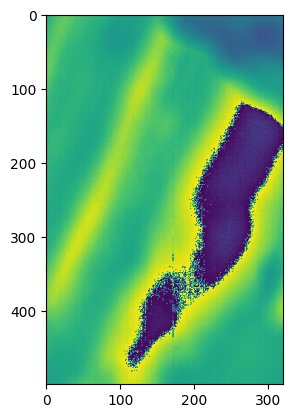



Done:  Aspergillus_niger_30d
(230, 500, 320)


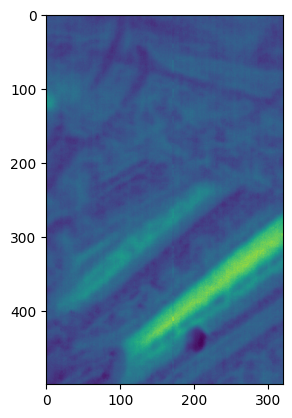



Done:  Aspergillus_niger_48h
(230, 500, 320)


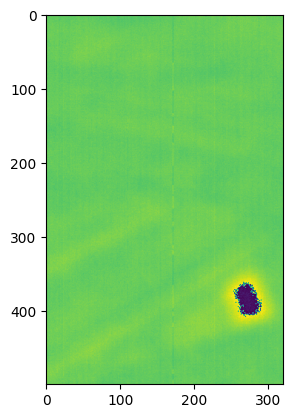



Done:  Aspergillus_niger_96h
(230, 500, 320)


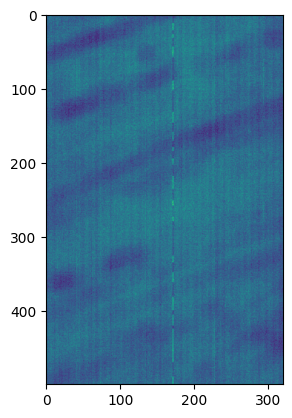



Done:  Aspergillus_terreus_14d
(230, 500, 320)


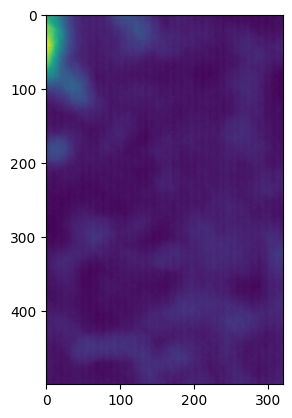



Done:  Aspergillus_terreus_30d
(230, 500, 320)


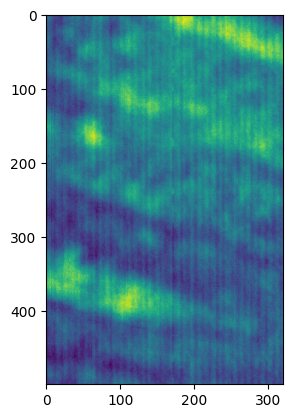



Done:  Aspergillus_terreus_48h
(230, 500, 320)


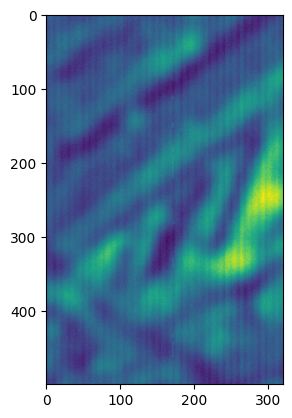



Done:  Aspergillus_terreus_96h
(230, 500, 320)


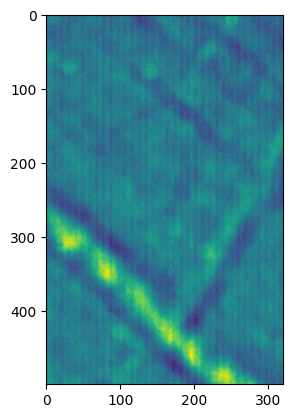



Done:  Candida_albicans_14d
(230, 500, 320)


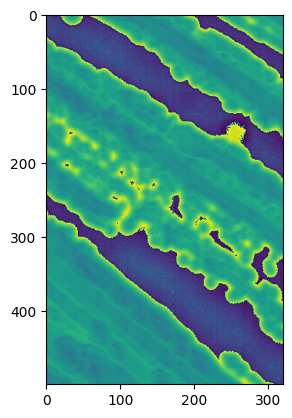



Done:  Candida_albicans_30d
(230, 500, 320)


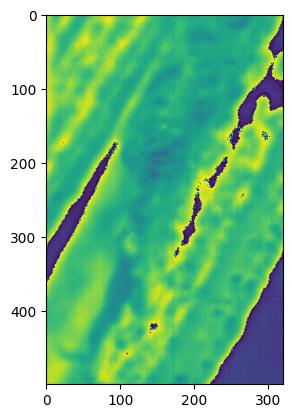



Done:  Candida_albicans_48h
(230, 500, 320)


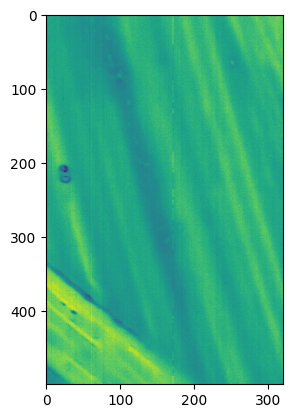



Done:  Candida_albicans_96h
(230, 500, 320)


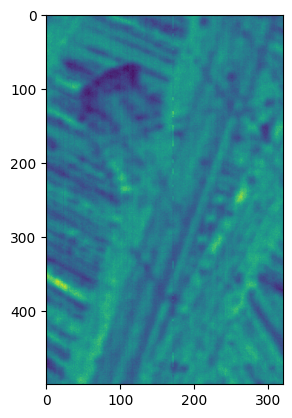



Done:  Fusarim_chlamydosporums_14d
(230, 500, 320)


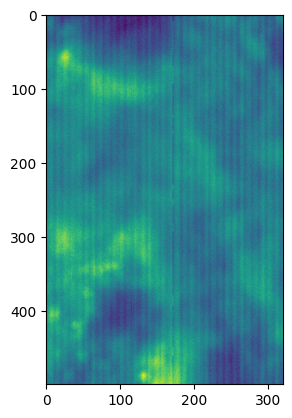



Done:  Fusarim_chlamydosporums_30d
(230, 500, 320)


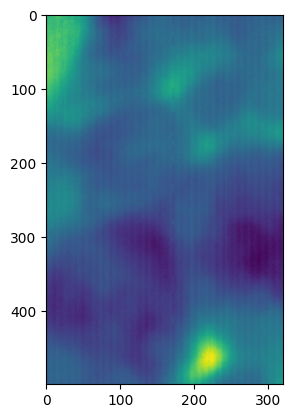



Done:  Fusarim_chlamydosporums_48h
(230, 500, 320)


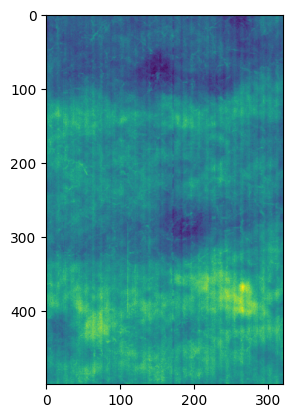



Done:  Fusarim_chlamydosporums_96h
(230, 500, 320)


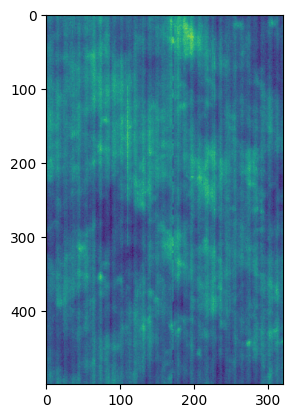



Done:  Penicillium_spp_14d
(230, 500, 320)


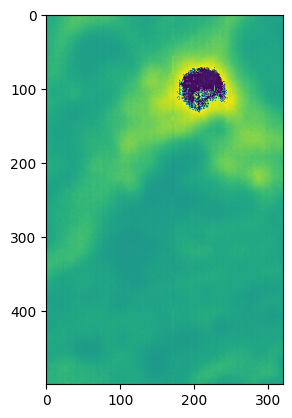



Done:  Penicillium_spp_30d
(230, 500, 320)


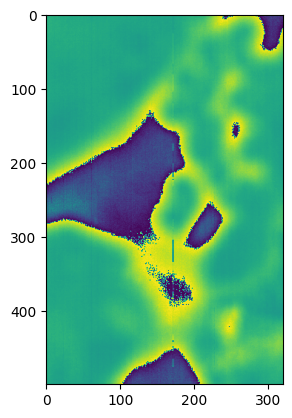



Done:  Penicillium_spp_48h
(230, 500, 320)


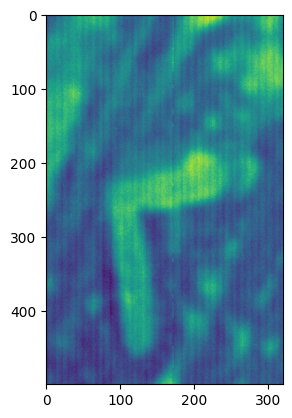



Done:  Penicillium_spp_96h
(230, 500, 320)


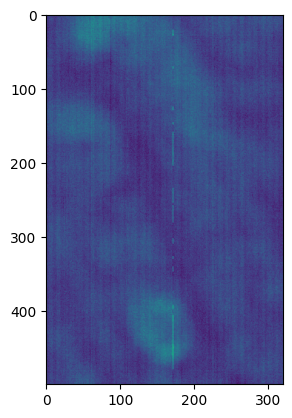

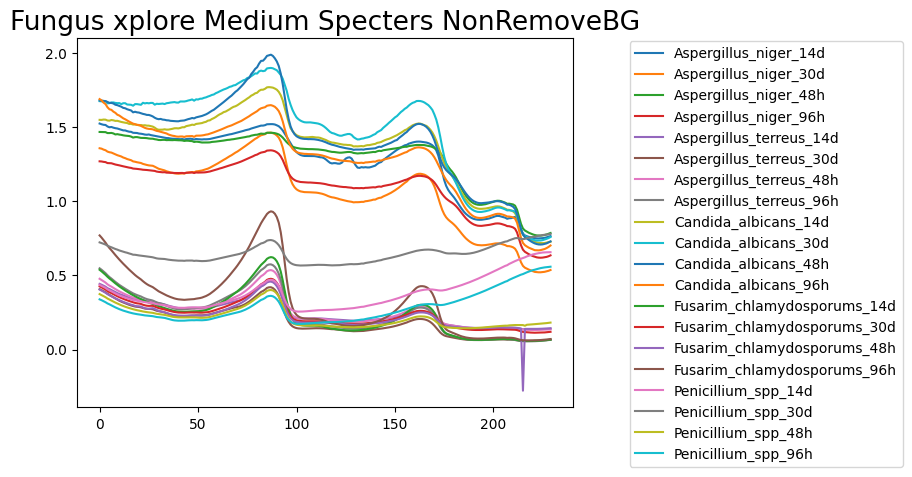

In [32]:
plot_mean_values={}
for i, key in enumerate(fungus_crop):
    
    name_file=key.split('_')
    name_sample='_'.join(name_file)
    
    samples_data[key]=hsi_crop(samples_data[key], fungus_crop[key])

    print('Done: ', name_sample)
    print(samples_data[key].shape)
    plt.imshow(rgbscale(samples_data[key][220,:,:]))
    plt.axis()
    plt.show()
    print('\n')
    
    #calculating the values ​​of each pixel, 
    # to plot the average spectra still with the background, for the cropped image
    data_temp=hsi2matrix(samples_data[key])
    
    value_list=[]
    for i in range(data_temp.shape[1]):
        value_list.append(data_temp[:,i].mean())
    
    plot_mean_values[key]=value_list


for i in plot_mean_values.keys():
    plt.plot(plot_mean_values[i], label=i)
# plt.savefig(folder+f'NonRemBG_medium_spectrunsPlot.png')
# plt.close(fig)
plt.title('Fungus xplore Medium Specters NonRemoveBG',fontsize=19)
plt.legend(bbox_to_anchor=(1.1, 1.01))
plt.savefig(folder+'xplore_Fungus.png', dpi=300)
plt.show()

In [ ]:
# plot_mean_values={}
# for i, key in enumerate(fungus_dict_cut):
    
#     name_file=key.split('_')
#     name_sample='_'.join(name_file)
    
#     fungus_data[key]=hsi_crop(fungus_data[key], fungus_dict_cut[key])

#     print('Done: ', name_sample)
#     print(fungus_data[key].shape)
#     plt.imshow(rgbscale(fungus_data[key][220,:,:]))
#     plt.axis()
#     plt.show()
#     print('\n')
    
#     #calculating the values ​​of each pixel, 
#     # to plot the average spectra still with the background, for the cropped image
#     data_temp=hsi2matrix(fungus_data[key])
    
#     value_list=[]
#     for i in range(data_temp.shape[1]):
#         value_list.append(data_temp[:,i].mean())
    
#     plot_mean_values[key]=value_list


# for i in plot_mean_values.keys():
#     plt.plot(plot_mean_values[i], label=i)
# # plt.savefig(folder+f'NonRemBG_medium_spectrunsPlot.png')
# # plt.close(fig)
# plt.title('Fungus Medium Specters NonRemoveBG',fontsize=19)
# plt.legend(bbox_to_anchor=(1.1, 1.01))
# plt.savefig(folder+'_Fungus.png', dpi=300)
# plt.show()

In [33]:
def save_cap_norm(data, dict, path):
    for idx, sample in enumerate(list(dict.keys())):
        # print(sample, idx)
        
        name_file=sample.split('_')
        name_sample='_'.join(name_file[:-1])
        
        sample_path = os.path.join(folder+path, name_sample)
        
        if os.path.isfile(sample_path + f'/{name_sample}.pkl'):
            print(f"{name_sample} normalized and save")
            continue

        os.makedirs(sample_path, exist_ok=True)
        sample_file = sample_path + f'/{name_sample}.pkl'
    
        with open(sample_file, 'wb') as destination_dir:
            pickle.dump(data[name_sample], destination_dir, -1)

        print('Done: ', name_sample)
        
save_cap_norm(samples_data, samples_dict, 'data_process/Rmicroplus/')
# save_cap_norm(samples_data, samples_dict, 'data_process/Rmicroplus/')
# save_cap_norm(fungus_data, fungus_dict, 'data_process/Fungus/')

Done:  Aspergillus_niger_14d
Done:  Aspergillus_niger_30d
Done:  Aspergillus_niger_48h
Done:  Aspergillus_niger_96h
Done:  Aspergillus_terreus_14d
Done:  Aspergillus_terreus_30d
Done:  Aspergillus_terreus_48h
Done:  Aspergillus_terreus_96h
Done:  Candida_albicans_14d
Done:  Candida_albicans_30d
Done:  Candida_albicans_48h
Done:  Candida_albicans_96h
Done:  Fusarim_chlamydosporums_14d
Done:  Fusarim_chlamydosporums_30d
Done:  Fusarim_chlamydosporums_48h
Done:  Fusarim_chlamydosporums_96h
Done:  Penicillium_spp_14d
Done:  Penicillium_spp_30d
Done:  Penicillium_spp_48h
Done:  Penicillium_spp_96h


## WORK WITH NORMALIZED AND CROP DATAS

### Clusters Select with Golay and SNV

In [20]:
dict_1, dict_2, dict_3, dict_4, dict_5, dict_6, dict_7 ={}, {},{}, {},{}, {},{}
data_dicts=[dict_1, dict_2, dict_3, dict_4, dict_5, dict_6, dict_7]

# folder_samples=['Rmicroplus', 'Manisopliae', 'Aspergillus_niger', 'Aspergillus_terreus', 'Candida', 'Fusarim', 'Penicillium' ]
folder_samples=['Rmicroplus', 'Manisopliae']

# folder='C:/Users/Usuario/Documents/UFG_Remoto/Projects/_HSI/Fungus/'
folder_2='C:/Users/Usuario/Documents/UFG_Remoto/Projects/_HSI/IPTSP_carrapatos/'
list_fl=[folder_2]

data_dicts=load_pkl(data_dicts, list_fl , folder_samples, golay=True, snv=True)

C:/Users/Usuario/Documents/UFG_Remoto/Projects/_HSI/IPTSP_carrapatos/data_process/Manisopliae\Fungo_Manisopliae_IP119_1/Fungo_Manisopliae_IP119_1.pkl
C:/Users/Usuario/Documents/UFG_Remoto/Projects/_HSI/IPTSP_carrapatos/data_process/Manisopliae\Fungo_Manisopliae_IP119_1_OutraRegiaoDaPlaca/Fungo_Manisopliae_IP119_1_OutraRegiaoDaPlaca.pkl
C:/Users/Usuario/Documents/UFG_Remoto/Projects/_HSI/IPTSP_carrapatos/data_process/Manisopliae\Fungo_Manisopliae_IP119_2_1/Fungo_Manisopliae_IP119_2_1.pkl
C:/Users/Usuario/Documents/UFG_Remoto/Projects/_HSI/IPTSP_carrapatos/data_process/Manisopliae\Fungo_Manisopliae_IP119_2_2/Fungo_Manisopliae_IP119_2_2.pkl
C:/Users/Usuario/Documents/UFG_Remoto/Projects/_HSI/IPTSP_carrapatos/data_process/Manisopliae\Fungo_Manisopliae_IP119_2_3/Fungo_Manisopliae_IP119_2_3.pkl
C:/Users/Usuario/Documents/UFG_Remoto/Projects/_HSI/IPTSP_carrapatos/data_process/Rmicroplus\Rmicroplus_Controle_TweenImersao_1/Rmicroplus_Controle_TweenImersao_1.pkl
C:/Users/Usuario/Documents/UFG_Re

In [ ]:
dict_info={}
for i,name in enumerate(folder_samples):
    samples_list_inds, samples_list_clusters = hsiImageProcess(data_dicts[i])

    dict_info[name]= {
                    'ind_': samples_list_inds,
                    'cluster_': samples_list_clusters
                     }

### Select proposed Filters for Data preparation

In [33]:
with open(folder+"dict_list_clusters.pkl", "wb") as tf:
    pickle.dump(dict_info,tf)

with open(folder+"dict_list_clusters.pkl", "wb") as tf:
    new_dict = pickle.load(tf)

print(new_dict.item())

UnsupportedOperation: read

In [49]:
# folder_samples=['Rmicroplus', 'Manisopliae', 'Aspergillus_niger', 'Aspergillus_terreus', 'Candida', 'Fusarim', 'Penicillium' ]
folder_samples=['Rmicroplus', 'Manisopliae']

folder='C:/Users/Usuario/Documents/UFG_Remoto/Projects/_HSI/Fungus/'
folder_2='C:/Users/Usuario/Documents/UFG_Remoto/Projects/_HSI/IPTSP_carrapatos/'
list_fl=[folder_2]

# dict_1, dict_2, dict_3, dict_4, dict_5, dict_6, dict_7 ={}, {},{}, {},{}, {},{}
dict_1, dict_2={},{}
# data_dicts=[dict_1, dict_2, dict_3, dict_4, dict_5, dict_6, dict_7]
data_dicts=[dict_1, dict_2]

data_dicts=load_pkl(data_dicts, list_fl , folder_samples, golay=False, snv=False)

for i, sample_class in enumerate(data_dicts):
    x=list(sample_class.keys())
    
    if 'Aspergillus' in x[0]:
        fir=x[0].split('_')[0]
        sec=x[0].split('_')[1]
        conc=[fir, sec]
        variable_name=('_').join(conc)
    else:
        variable_name=x[0].split('_')[0]
    
    if 'Fungo' in variable_name:
        variable_name=  'Manisopliae'
    # print(variable_name)
    key='data_'
    dict_info[variable_name][key]= data_dicts[i]

C:/Users/Usuario/Documents/UFG_Remoto/Projects/_HSI/IPTSP_carrapatos/data_process/Manisopliae\Fungo_Manisopliae_IP119_1/Fungo_Manisopliae_IP119_1.pkl
C:/Users/Usuario/Documents/UFG_Remoto/Projects/_HSI/IPTSP_carrapatos/data_process/Manisopliae\Fungo_Manisopliae_IP119_1_OutraRegiaoDaPlaca/Fungo_Manisopliae_IP119_1_OutraRegiaoDaPlaca.pkl
C:/Users/Usuario/Documents/UFG_Remoto/Projects/_HSI/IPTSP_carrapatos/data_process/Manisopliae\Fungo_Manisopliae_IP119_2_1/Fungo_Manisopliae_IP119_2_1.pkl
C:/Users/Usuario/Documents/UFG_Remoto/Projects/_HSI/IPTSP_carrapatos/data_process/Manisopliae\Fungo_Manisopliae_IP119_2_2/Fungo_Manisopliae_IP119_2_2.pkl
C:/Users/Usuario/Documents/UFG_Remoto/Projects/_HSI/IPTSP_carrapatos/data_process/Manisopliae\Fungo_Manisopliae_IP119_2_3/Fungo_Manisopliae_IP119_2_3.pkl
C:/Users/Usuario/Documents/UFG_Remoto/Projects/_HSI/IPTSP_carrapatos/data_process/Rmicroplus\Rmicroplus_Controle_TweenImersao_1/Rmicroplus_Controle_TweenImersao_1.pkl
C:/Users/Usuario/Documents/UFG_Re

In [50]:
dict_info.keys()

dict_keys(['Rmicroplus', 'Manisopliae'])

In [51]:
dict_info['Rmicroplus']['data_'].keys()

dict_keys(['Rmicroplus_Controle_TweenImersao_1', 'Rmicroplus_Controle_TweenImersao_2', 'Rmicroplus_Controle_TweenInjecao_1', 'Rmicroplus_Controle_TweenInjecao_2', 'Rmicroplus_Controle_Zero_1', 'Rmicroplus_Controle_Zero_2', 'Rmicroplus_Imersao_12h_1', 'Rmicroplus_Imersao_12h_2', 'Rmicroplus_Imersao_24h_1', 'Rmicroplus_Imersao_24h_2', 'Rmicroplus_Imersao_24h_3', 'Rmicroplus_Injecao_12h_1', 'Rmicroplus_Injecao_6h_1', 'Rmicroplus_Injecao_6h_2'])

In [53]:
dict_info['Manisopliae']['data_'].keys()

dict_keys(['Fungo_Manisopliae_IP119_1', 'Fungo_Manisopliae_IP119_1_OutraRegiaoDaPlaca', 'Fungo_Manisopliae_IP119_2_1', 'Fungo_Manisopliae_IP119_2_2', 'Fungo_Manisopliae_IP119_2_3'])

In [72]:
# def visualizate_clusters(tittle, sample_cluster, image, cut=None):

# #   image = moveAxis(image)
#   image=image[210,:,:]
#   out_i = getClusters(image, sample_cluster, 0, (1, 1, 1))
#   plt.title(tittle)
#   plt.imshow(rgbscale(out_i))
#   plt.axis()
#   plt.show()
#   print('\n')
  
# for key in fungus_data.keys():
#   visualizate_clusters(key, fungus_list_clusters[key], 
#                       fungus_data[key])

# for key in samples_data.keys():
#   visualizate_clusters(key, samples_list_clusters[key], 
#                       samples_data[key])

In [74]:
# teste2 = np.arange(48).reshape(-1, 4, 4) 
# kmeans_result = np.array([0, 0, 1, 1, 1, 1, 0,0, 1, 1, 1, 1])

# print(teste2)

# X_train0, X_test0, y_train1, y_test1 = get_Xy(teste2, 0.5, kmeans_result, 1)

### Creating Data for training and test

In [84]:
def get_Xy(DATA, info, sample_cluster, spectral_range=(0, 231)):

    X_test = np.array([]).reshape(0, spectral_range[1] - spectral_range[0])
    X_train = np.array([]).reshape(0, spectral_range[1] - spectral_range[0])
    y_test = np.array([]).reshape(-1, 1)
    y_train = np.array([]).reshape(-1, 1)

    for key in DATA.keys():
        data = DATA[key]
        # data = moveAxis(data)
        matrix = hsi2matrix(data)
        matrix = matrix[:, spectral_range[0]:spectral_range[1]]

        ind, _ = sum_idx_array(realIdx(sample_cluster[key], 1))

        idx_train, idx_test = train_test_split(ind, test_size=info[key][1], shuffle=False)

        X_test = np.vstack([X_test, matrix[idx_test]])
        X_train = np.vstack([X_train, matrix[idx_train]])

        # print(key,'----->', data.shape, data[150,140,:])
        # print(X_train, X_test)
        # print(idx_train.shape, idx_test.shape)

        #Setando os targets
        y = np.ones(idx_train.shape) * info[key][0]
        y = y.reshape(-1, 1)
        y_train = np.vstack([y_train, y])

        y = np.ones(idx_test.shape) * info[key][0] 
        y = y.reshape(-1, 1)
        y_test = np.vstack([y_test, y])

        # print(X_train, y_train, '\n', X_train.shape, y_train.shape)

        # VISUALIZATION
        # size_train = len(sample_cluster[key]) * (1 - info[key][1])

        # X_train_separation = sample_cluster[key][:int(size_train)]
        # X_test_separation = sample_cluster[key][len(X_train_separation):]

        # X_test_separation_aux = np.ones(len(X_test_separation)) * 2
        # idx_test, rem = sum_idx_array(realIdx(X_test_separation, 1))
        # X_test_separation = rev_idx_array(idx_test, rem, tfill=X_test_separation_aux)

        # sample_cluster_visualizate = np.concatenate((X_train_separation, X_test_separation))
        # visualization_sample_separation(data[50,:,:], sample_cluster_visualizate, key)

    return X_train, X_test, y_train, y_test


def visualization_sample_separation(image, sample_cluster, key, X_train_size=None, X_test_size=None):
    image = getClusters(image, sample_cluster, 1, (1, 0, 0))
    image = getClusters(image, sample_cluster, 2, (0, 1, 0))

    red_patch = mpatches.Patch(color='red', label='Trian size')
    green_patch = mpatches.Patch(color='green', label='Test size')

    fig, ax = plt.subplots(figsize=(12,8))

    ax.axis()
    ax.imshow(rgbscale(image))
    fig.legend(title='Separation', handles=[red_patch, green_patch], loc='center right')
    plt.title('Sample: ' + key)
    plt.show()


def get_Xy_DataFrame(DATA, sample_cluster, target, exception=list, spectral_range=(0, 231)):
    df = pd.DataFrame()

    X_ = np.array([]).reshape(0, spectral_range[1] - spectral_range[0])
    y_ = np.array([]).reshape(-1, 1)

    for key in DATA.keys():
        
        temp=[key for name in exception if name in key]
        if len(temp)>0:
            # print(temp)
            continue
        
        data = DATA[key]
        
        matrix = hsi2matrix(data)
        matrix = matrix[:, spectral_range[0]:spectral_range[1]]

        ind, _ = sum_idx_array(realIdx(sample_cluster[key], 1))

        X_ = pd.DataFrame(matrix[ind])
        
        y = np.ones(ind.shape)*target
        y = y.reshape(-1, 1)
        y_ = np.vstack([y_, y])
        
        df = df.append(X_)

    df = df.assign(target = y_)
    df.columns = [f'band-{i}' for i in range(1,231)]+['target']

    return df

def plot_spectrum_analysis(dict_samples, ind_, df, name_file, tittle, tam0, exception=list):
    dict_plot={}
    for key in dict_samples:  
        temp=[key for name in exception if name in key]
        if len(temp)>0:
            # print(temp)
            continue
        
        tam=ind_[key].shape[0]
        tam=(tam+tam0)
        dict_plot[key]=df.iloc[tam0:tam,:230]
        tam0=tam
              
    print(dict_plot.keys())
    # #all Spectral
    plt.figure(figsize=(16,8))
    for i, sample in enumerate(dict_plot.keys()):
        plt.plot(dict_plot[sample].mean(), label=sample)
    plt.title(f'Average spectrum captures by samples for training',fontsize=19)
    plt.legend(fontsize=16)
    plt.xticks(range(4, 231, 15), rotation=50)
    plt.rcParams['xtick.labelsize'] = 14
    plt.rcParams['ytick.labelsize'] = 14
    
    plt.savefig(folder_2+f'spectrum_{name_file}_{tittle}.pdf', dpi=300)
    # plt.close(fig)
    plt.show()
  
    return dict_plot, tam0

C:\Users\Usuario\AppData\Local\Temp\ipykernel_12108\2075862858.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(X_)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_12108\2075862858.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(X_)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_12108\2075862858.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(X_)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_12108\1073920112.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_train= df_train.append(get_Xy_DataFrame(dict_info[sample_class]['data_'],


dict_keys(['Rmicroplus_Controle_TweenImersao_1', 'Rmicroplus_Controle_TweenImersao_2', 'Rmicroplus_Controle_TweenInjecao_1', 'Rmicroplus_Controle_TweenInjecao_2', 'Rmicroplus_Controle_Zero_2'])


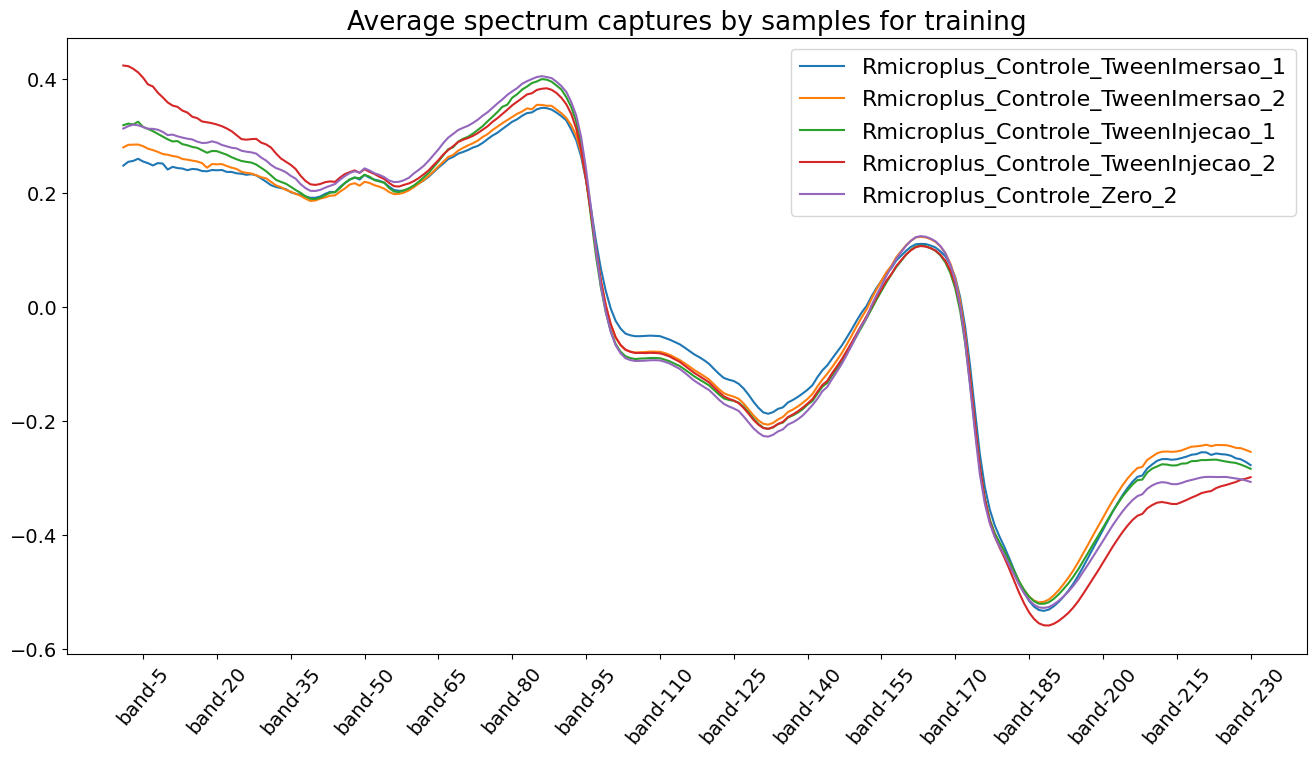

C:\Users\Usuario\AppData\Local\Temp\ipykernel_12108\2075862858.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(X_)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_12108\2075862858.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(X_)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_12108\2075862858.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(X_)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_12108\1073920112.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_train= df_train.append(get_Xy_DataFrame(dict_info[sample_class]['data_'],


dict_keys(['Fungo_Manisopliae_IP119_1', 'Fungo_Manisopliae_IP119_1_OutraRegiaoDaPlaca', 'Fungo_Manisopliae_IP119_2_1', 'Fungo_Manisopliae_IP119_2_2', 'Fungo_Manisopliae_IP119_2_3'])


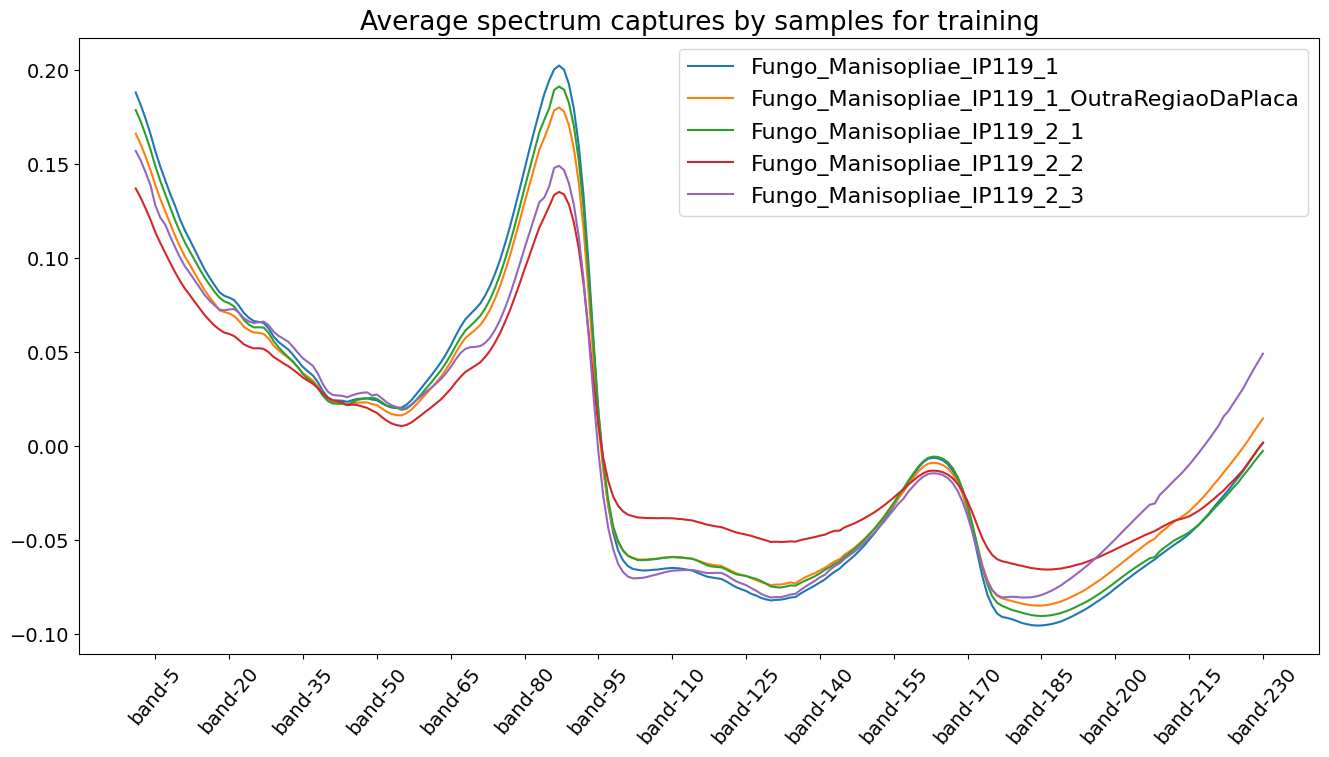

In [85]:
# Targets: 0 -> Fungus
#          1 -> R. Microplus controle

folder_2='C:/Users/Usuario/Documents/UFG_Remoto/Projects/_HSI/IPTSP_carrapatos/'
train_exception=['Meio', 'Rmicroplus_Controle_Zero_1', '_Injecao', '_Imersao']
df_train, dict_plot=pd.DataFrame(), {}
num_spectrus=230
target=1
tam=0

for i, sample_class in enumerate(dict_info.keys()):
    
    df_train= df_train.append(get_Xy_DataFrame(dict_info[sample_class]['data_'],
                                               dict_info[sample_class]['cluster_'], 
                                               target=target, exception=list(train_exception)),
                                               ignore_index=True)
    target=target+1

    var_values, tam=plot_spectrum_analysis(dict_info[sample_class]['data_'], dict_info[sample_class]['ind_'], 
                                         df_train, 'train', sample_class, tam, exception=list(train_exception))
    
    dict_plot[sample_class]=var_values

# Scrambling training data
df_train = shuffle(df_train)


In [71]:
dict_plot.keys()

dict_keys(['Rmicroplus', 'Manisopliae'])

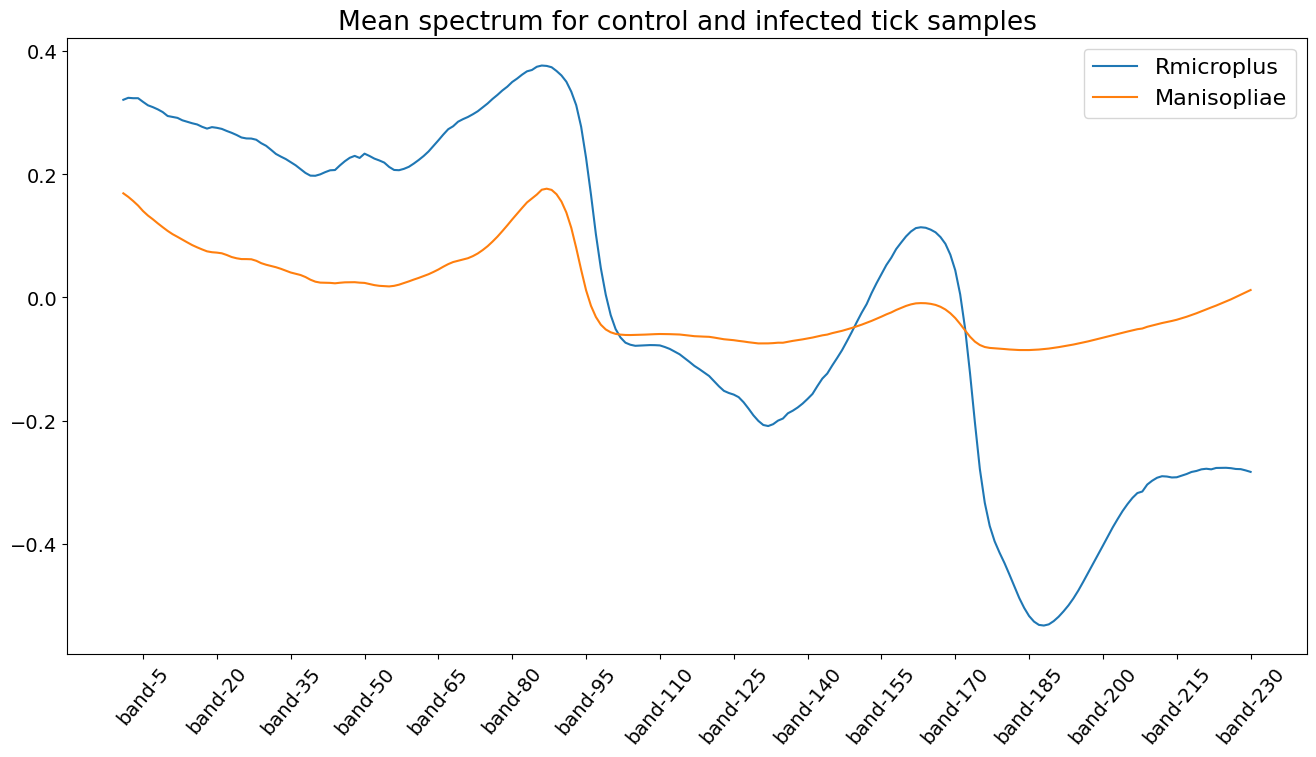

In [116]:
plt.figure(figsize=(16,8))
for i, samples in enumerate(dict_plot.keys()):
    df=pd.DataFrame()
    for y, samples_pclass in enumerate(dict_plot[samples]):
        df=pd.concat([df, dict_plot[samples][samples_pclass]])
    plt.plot(df.mean(), label=samples)
plt.title(f'Mean spectrum for control and infected tick samples',fontsize=19)
plt.legend(fontsize=16)
plt.xticks(range(4, 230, 15), rotation=50)
plt.savefig(folder_2+f'meanSpectrus.pdf', dpi=300)
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
# plt.close(fig)
plt.show()

In [52]:
df_train

band-1    band-2    band-3    band-4    band-5    band-6    band-7  \
2078376  0.276383  0.295101  0.248720  0.267152  0.265139  0.271009  0.315844   
1238033  0.143992  0.109992  0.140853  0.180958  0.174578  0.176029  0.195092   
556023   0.126413  0.123866  0.123185  0.112425  0.100178  0.090636  0.086169   
1292588  0.102968  0.120564  0.161426  0.168677  0.127214  0.138096  0.141398   
524335   0.182644  0.169430  0.168114  0.161367  0.157735  0.145706  0.138136   
...           ...       ...       ...       ...       ...       ...       ...   
986591   0.268638  0.282806  0.259867  0.270504  0.153601  0.234143  0.202081   
2123201  0.550997  0.371335  0.648608  0.153479 -2.030736 -2.030736  0.294588   
1108284  0.286125  0.204610  0.233816  0.233544  0.269299  0.233871  0.229472   
1027653  0.334965  0.275683  0.329730  0.274232  0.312698  0.258765  0.263742   
92262    0.231673  0.338504  0.177561  0.247229  0.283804  0.310567  0.281537   

           band-8    band-9   band-10  ...  band-222  band-223  band-224  \
2078376  0.252092  0.227116  0.242191  ... -0.532965 -0.525332 -0.537447   
1238033  0.160487  0.160483  0.161601  ... -0.479985 -0.471701 -0.468602   
556023   0.083473  0.077523  0.082375  ...  0.024169  0.030292  0.029403   
1292588  0.181451  0.129780  0.162015  ... -0.480329 -0.486209 -0.492287   
524335   0.134292  0.125519  0.116799  ... -0.001948  0.007740  0.009868   
...           ...       ...       ...  ...       ...       ...       ...   
986591   0.235706  0.265802  0.253701  ... -0.567998 -0.562257 -0.582368   
2123201  0.609269  0.532887  0.301714  ... -1.287311 -1.295627 -1.275313   
1108284  0.223746  0.193077  0.231811  ... -0.558974 -0.564283 -0.577740   
1027653  0.260272  0.245929  0.290224  ... -0.567981 -0.566158 -0.561396   
92262    0.355133  0.194434  0.338346  ... -0.331045 -0.313898 -0.327763   

         band-225  band-226  band-227  band-228  band-229  band-230  target  
2078376 -0.545641 -0.544428 -0.542207 -0.523796 -0.531527 -0.550985     5.0  
1238033 -0.471347 -0.484827 -0.491619 -0.462414 -0.496156 -0.434487     3.0  
556023   0.028601  0.037024  0.042551  0.051190  0.057794  0.053884     2.0  
1292588 -0.472346 -0.500767 -0.478901 -0.480756 -0.459718 -0.476225     3.0  
524335   0.014142  0.007552  0.017769  0.014906  0.030882  0.034040     2.0  
...           ...       ...       ...       ...       ...       ...     ...  
986591  -0.574874 -0.568072 -0.568551 -0.545342 -0.547062 -0.543645     3.0  
2123201 -1.304468 -1.270393 -1.261430 -1.252255 -1.251841 -1.292690     5.0  
1108284 -0.587201 -0.570062 -0.565839 -0.556375 -0.578572 -0.540960     3.0  
1027653 -0.561900 -0.563266 -0.564542 -0.560470 -0.556044 -0.546842     3.0  
92262   -0.355460 -0.349670 -0.363000 -0.389118 -0.305544 -0.348787     1.0  

[3409575 rows x 231 columns]

In [42]:
len(df_train.loc[df_train['target']==7.0]), len(df_train.loc[df_train['target']==1.0]), len(df_train.loc[df_train['target']==2.0]), len(df_train.loc[df_train['target']==3.0]), len(df_train.loc[df_train['target']==4.0]), len(df_train.loc[df_train['target']==5.0]), len(df_train.loc[df_train['target']==6.0])

(539076, 344952, 568885, 430389, 616803, 409969, 492010)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_25540\394058541.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(X_)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_25540\917672181.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_val=df_val.append(get_Xy_DataFrame(samples_data, samples_list_clusters, target=1, exception=val_exeption), ignore_index=True)


dict_keys(['Rmicroplus_Controle_Zero_1'])


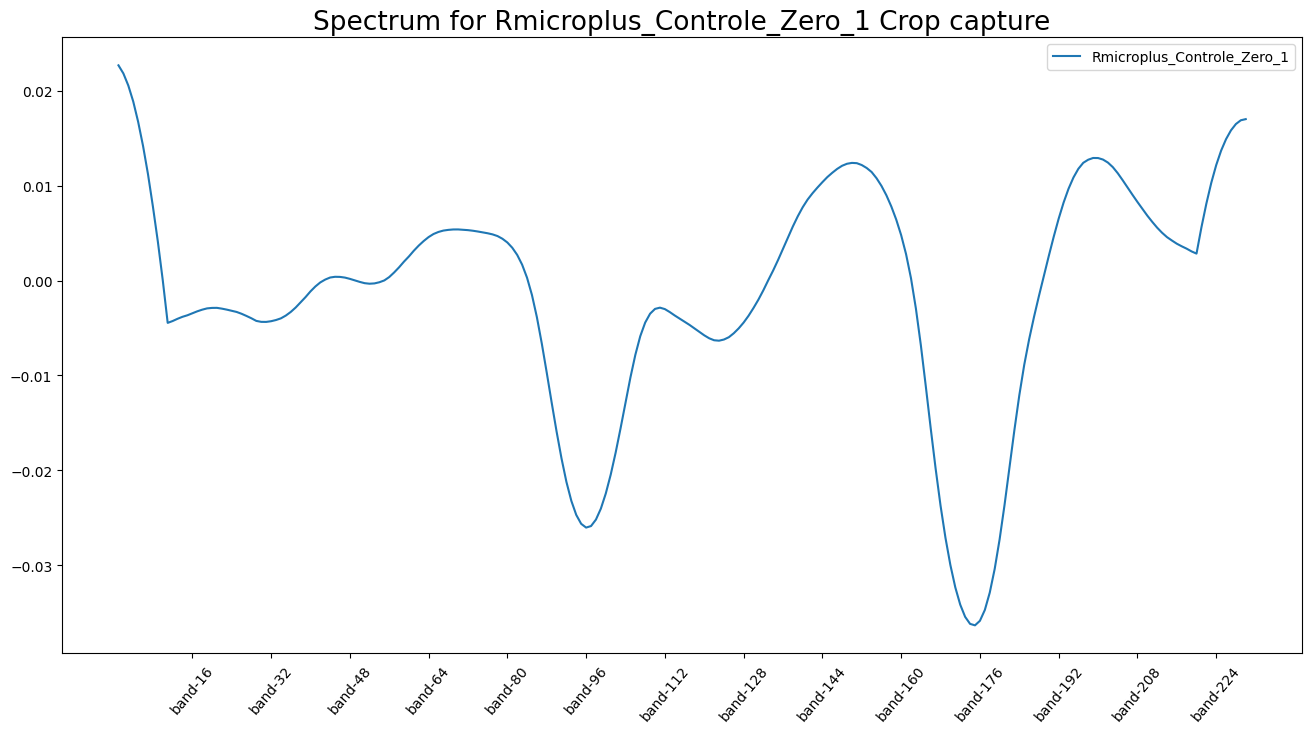

In [58]:
# Targets: 0 -> Fungus
#          1 -> R. Microplus controle

# val_exeption=list(samples_data.keys())
# val_exeption.remove('Rmicroplus_Controle_Zero_1')

df_val=pd.DataFrame()

# df_val= get_Xy_DataFrame(fungus_data, fungus_list_clusters, target=0)
df_val=df_val.append(get_Xy_DataFrame(samples_data, samples_list_clusters, target=1, exception=val_exeption), ignore_index=True)

plot_spectrum_analysis(samples_data, samples_list_inds, df_val ,
                       'Validation-Rmicroplus_Controle_Zero_1', 'Rmicroplus_Controle_Zero_1', tam0=0, exception=list(val_exeption))

# Scrambling valing data
df_val = shuffle(df_val)

In [68]:
dict_info['Rmicroplus']['data_'].keys()

dict_keys(['Rmicroplus_Controle_TweenImersao_1', 'Rmicroplus_Controle_TweenImersao_2', 'Rmicroplus_Controle_TweenInjecao_1', 'Rmicroplus_Controle_TweenInjecao_2', 'Rmicroplus_Controle_Zero_1', 'Rmicroplus_Controle_Zero_2', 'Rmicroplus_Imersao_12h_1', 'Rmicroplus_Imersao_12h_2', 'Rmicroplus_Imersao_24h_1', 'Rmicroplus_Imersao_24h_2', 'Rmicroplus_Imersao_24h_3', 'Rmicroplus_Injecao_12h_1', 'Rmicroplus_Injecao_6h_1', 'Rmicroplus_Injecao_6h_2'])

C:\Users\Usuario\AppData\Local\Temp\ipykernel_12108\2075862858.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(X_)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_12108\2075862858.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(X_)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_12108\2075862858.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(X_)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_12108\2075862858.py:94: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(X_)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_12108\2075862858.py:94: FutureWarning: The frame.append me

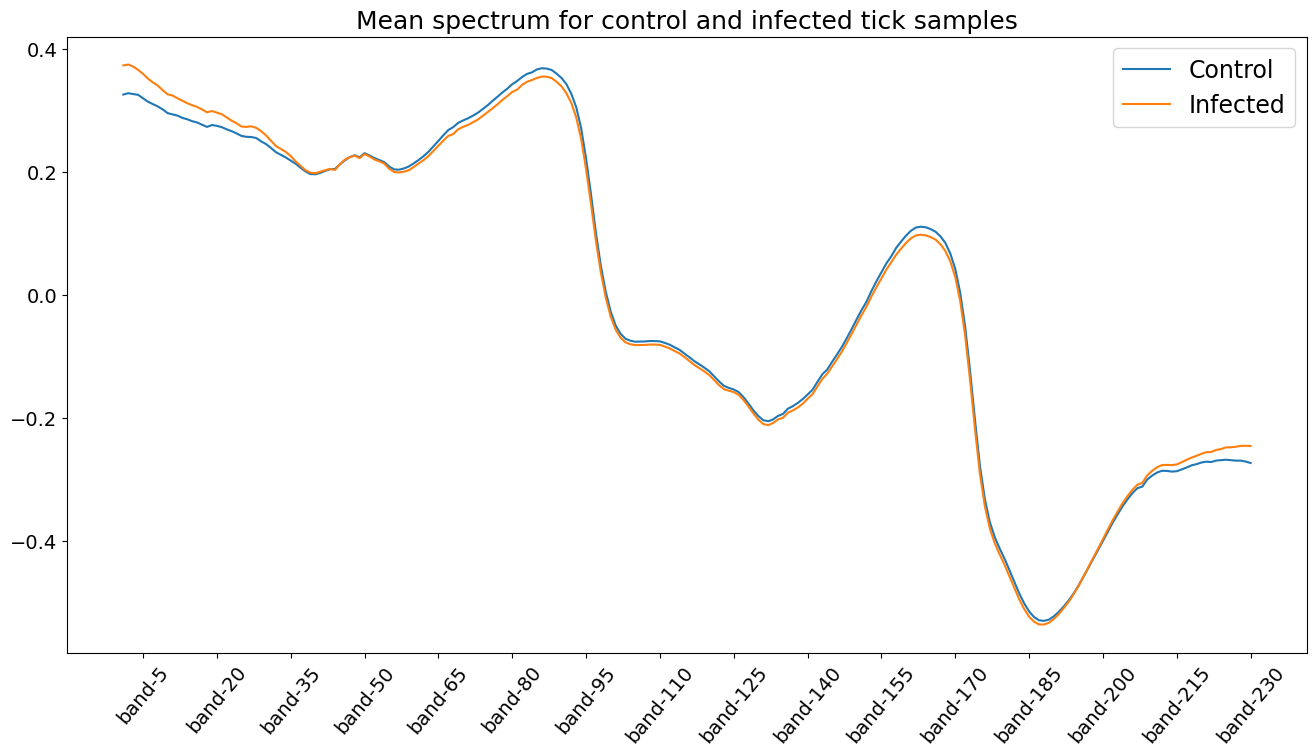

In [115]:
train_exception=['Meio', '_Injecao', '_Imersao']
df_train_control=get_Xy_DataFrame(dict_info['Rmicroplus']['data_'], dict_info['Rmicroplus']['cluster_'], target=1, exception=list(train_exception))
# plot_spectrum_analysis(samples_data, samples_list_inds, df_train_control ,
#                        'Train-RMicroplus_Crop_all_spectrum_1', 'RMicroplus', tam0=0, exception=list(train_exception))
train_exception=['Meio', 'Controle']
df_train_infected=get_Xy_DataFrame(dict_info['Rmicroplus']['data_'], dict_info['Rmicroplus']['cluster_'], target=1, exception=list(train_exception))

df_plot=df_train_control.drop(columns=['target'])
df_plot=df_plot.sum()/len(df_train_control)

df_plot_test=df_train_infected.drop(columns=['target'])
df_plot_test=df_plot_test.sum()/len(df_train_infected)

plt.figure(figsize=(16,8))
plt.plot(df_plot, label="Control")
plt.plot(df_plot_test, label="Infected")
plt.xticks(range(4, len(df_plot), 15), rotation=50)
plt.title('Mean spectrum for control and infected tick samples', fontsize=18)
plt.legend(fontsize=17)
plt.savefig(folder_2+"controlVSinfected_output_nonFilter.pdf", dpi=300) 

In [86]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                      df_train:  1.6 GiB
                            df: 975.6 MiB
             df_train_infected: 863.4 MiB
              df_train_control: 729.0 MiB
                          _i29: 16.7 KiB
                          _i37: 16.7 KiB
                          _i27: 16.7 KiB
                          _i26: 16.7 KiB
                          _i31: 16.7 KiB
                          _i33: 16.7 KiB


# Classification

### Classifier Grid Search

In [88]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.gaussian_process import GaussianProcessClassifier

dict_classifiers = {
    # "Logistic Regression": LogisticRegression(),
    #"Nearest Neighbors": KNeighborsClassifier(),
    "LinearSVM": SVC(verbose=2),
    # "Gradient Boosting Classifier": GradientBoostingClassifier(n_estimators=100, verbose=2),
    # "Decision Tree": tree.DecisionTreeClassifier(),
    "RandomForest": RandomForestClassifier(n_estimators=50, verbose=2),
    "NeuralNet": MLPClassifier(hidden_layer_sizes=(256,128,64,32),activation="relu",random_state=1, alpha = 1,  verbose=2),
    "Neural512": MLPClassifier(activation= 'relu', alpha= 0.005, hidden_layer_sizes= (230, 128, 64), learning_rate= 'adaptive', solver= 'adam'),
    #"Naive Bayes": GaussianNB(),
    #"AdaBoost": AdaBoostClassifier(),
    #"QDA": QuadraticDiscriminantAnalysis(),     ## Atualiza uma regressão logística para lidar com problemas não lineares
    # "Gaussian Process": GaussianProcessClassifier()
}

In [89]:
def batch_classify(X_train, y_train, X_test, y_test, no_classifiers, verbose = True):
    """
    This method, takes as input the X, Y matrices of the Train and Test set.
    And fits them on all of the Classifiers specified in the dict_classifier.
    The trained models, and accuracies are saved in a dictionary. The reason to use a dictionary
    is because it is very easy to save the whole dictionary with the pickle module.
    
    Usually, the SVM, Random Forest and Gradient Boosting Classifier take quiet some time to train. 
    So it is best to train them on a smaller dataset first and 
    decide whether you want to comment them out or not based on the test accuracy score.
    """
    
    dict_models = {}
    for classifier_name, classifier in list(dict_classifiers.items())[:no_classifiers]:
        # t_start = time.clock()
        print(classifier_name)
        history=classifier.fit(X_train, y_train)
        # t_end = time.clock()
        
        # t_diff = t_end - t_start
        train_score = classifier.score(X_train, y_train)
        test_score = classifier.score(X_test, y_test)
        
        dict_models[classifier_name] = {'model': classifier, 'train_score': train_score, 'test_score': test_score}
        if verbose:
            print("trained {c}".format(c=classifier_name))
    return dict_models


def display_dict_models(dict_models, sort_by='test_score'):
    cls = [key for key in dict_models.keys()]
    test_s = [dict_models[key]['test_score'] for key in cls]
    training_s = [dict_models[key]['train_score'] for key in cls]
    
    df_ = pd.DataFrame(data=np.zeros(shape=(len(cls),3)), columns = ['classifier', 'train_score', 'test_score'])
    for ii in range(0,len(cls)):
        df_.loc[ii, 'classifier'] = cls[ii]
        df_.loc[ii, 'train_score'] = training_s[ii]
        df_.loc[ii, 'test_score'] = test_s[ii]
    
    display(df_.sort_values(by=sort_by, ascending=False))

In [122]:
dict_models={}

for i, path in enumerate(glob.glob(folder+'load_models/*')):
    print(path)
    name_model=path.split('\\')[1].split('.')[0].split('_')[0]
    dict_models[name_model]={'model': load(path)}

C:/Users/Usuario/Documents/UFG_Remoto/Projects/_HSI/Fungus/load_models\non_filters


PermissionError: [Errno 13] Permission denied: 'C:/Users/Usuario/Documents/UFG_Remoto/Projects/_HSI/Fungus/load_models\\non_filters'

In [93]:
os.makedirs(os.path.join(folder_2+'load_models'), exist_ok=True)

#Results Visualization

In [94]:
# inicio = time.time()
train, val = train_test_split(df_train, test_size=0.2, shuffle=True)

dict_models = batch_classify(train.iloc[:,:num_spectrus], train.iloc[:,num_spectrus], val.iloc[:,:num_spectrus],
                             val.iloc[:,num_spectrus], no_classifiers = 3, verbose = True)
display_dict_models(dict_models)

for i, model in enumerate(dict_models.keys()):
    with open(folder+f'load_models/{model}_model.pkl', 'wb') as f:
        pickle.dump(dict_models[str(model)]['model'], f)

# fim = time.time()
# print(fim - inicio)

LinearSVM
[LibSVM]trained LinearSVM
RandomForest


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.2s remaining:    0.0s


building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  4.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished


trained RandomForest
NeuralNet
Iteration 1, loss = 0.06905495
Iteration 2, loss = 0.03910417
Iteration 3, loss = 0.03871167
Iteration 4, loss = 0.03857357
Iteration 5, loss = 0.03848542
Iteration 6, loss = 0.03850254
Iteration 7, loss = 0.03846971
Iteration 8, loss = 0.03845275
Iteration 9, loss = 0.03844255
Iteration 10, loss = 0.03844966
Iteration 11, loss = 0.03840958
Iteration 12, loss = 0.03841898
Iteration 13, loss = 0.03842286
Iteration 14, loss = 0.03839806
Iteration 15, loss = 0.03838006
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
trained NeuralNet


classifier  train_score  test_score
0     LinearSVM     1.000000    1.000000
1  RandomForest     1.000000    1.000000
2     NeuralNet     0.999345    0.999406

In [96]:
y_hat_test=dict_models['RandomForest']['model'].predict(val.iloc[:,:230])

print(classification_report(np.array(val.iloc[:,230]), y_hat_test, target_names=folder_samples))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished


              precision    recall  f1-score   support

  Rmicroplus       1.00      1.00      1.00     68872
 Manisopliae       1.00      1.00      1.00    111318

    accuracy                           1.00    180190
   macro avg       1.00      1.00      1.00    180190
weighted avg       1.00      1.00      1.00    180190



In [99]:
y_hat_test=dict_models['NeuralNet']['model'].predict(val.iloc[:,:230])

print(classification_report(np.array(val.iloc[:,230]), y_hat_test,target_names=folder_samples))

              precision    recall  f1-score   support

  Rmicroplus       1.00      1.00      1.00     68872
 Manisopliae       1.00      1.00      1.00    111318

    accuracy                           1.00    180190
   macro avg       1.00      1.00      1.00    180190
weighted avg       1.00      1.00      1.00    180190



In [100]:
y_hat_test=dict_models['LinearSVM']['model'].predict(val.iloc[:,:230])

print(classification_report(np.array(val.iloc[:,230]), y_hat_test, target_names=folder_samples))

              precision    recall  f1-score   support

  Rmicroplus       1.00      1.00      1.00     68872
 Manisopliae       1.00      1.00      1.00    111318

    accuracy                           1.00    180190
   macro avg       1.00      1.00      1.00    180190
weighted avg       1.00      1.00      1.00    180190



In [74]:
os.makedirs(os.path.join(folder+'load_models'), exist_ok=True)

In [40]:
folder_samples

['Rmicroplus',
 'Manisopliae',
 'Aspergillus_niger',
 'Aspergillus_terreus',
 'Candida',
 'Fusarim',
 'Penicillium']

c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Rmicroplus_Controle_Zero_1 
Only one target value: False
[1 0 0 ... 0 0 0] (66896,) (66896,) (160000,) (160000, 230)


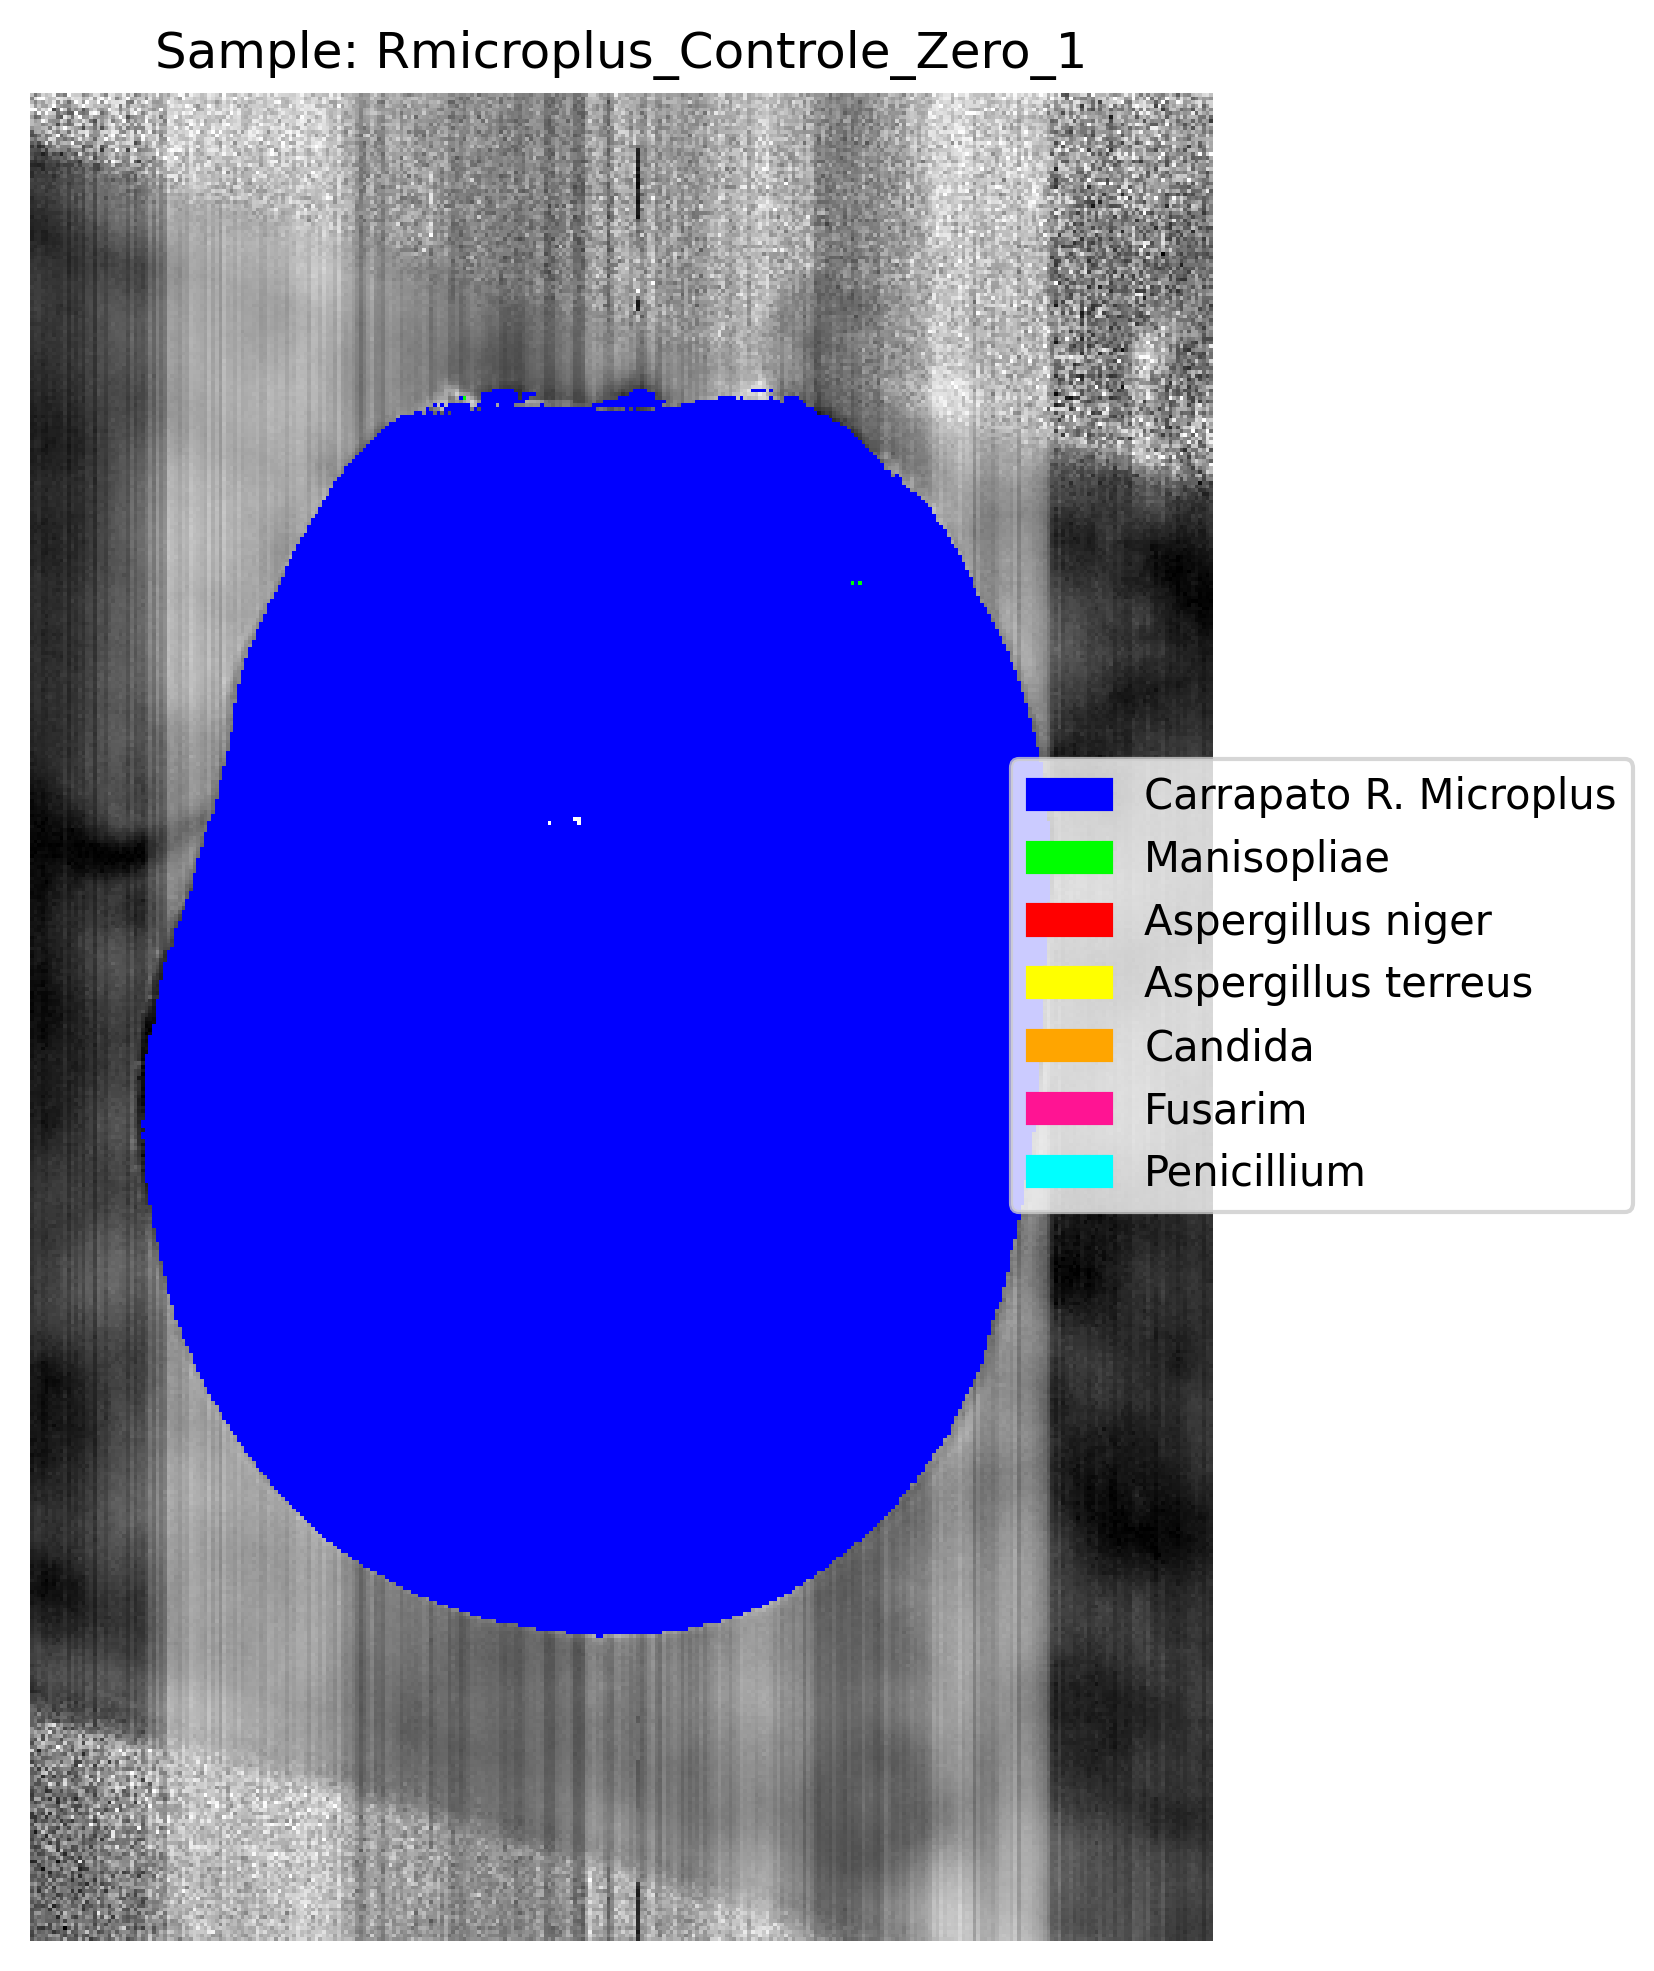

In [102]:
# 1 -> Carrapato R. Microplus
# 2 -> Manisopliae
# 3 -> Aspergillus_niger
# 4 -> Aspergillus_terreus
# 5 -> Candida
# 6 -> Fusarim
# 7 -> Penicillium

colors = {
            '1': ['#0000FF', 'Carrapato R. Microplus'],#azul
            '2': ['#00FF00', 'Manisopliae'],#verde
            '3': ['#FF0000', 'Aspergillus niger'],#vermelho
            '4': ['#FFFF00', 'Aspergillus terreus'],#amarelo
            '5': ['#FFA500', 'Candida'],#laranja
            '6': ['#FF1493', 'Fusarim'],#rosa
            '7': ['#00FFFF', 'Penicillium'],#cyan
        }

#aqui plota somente resultados do tamanho do X_test da amostra
def result_visualization_val(DATA, key, sample_cluster, classifier, spectral_range=(0, num_spectrus)):
    
    title = key
    data = DATA[key]

    matrix = hsi2matrix(data)
    matrix = matrix[:, spectral_range[0]:spectral_range[1]]

    ind, _ = sum_idx_array(realIdx(sample_cluster[key], 1))
    # idx_train, idx_test = train_test_split(ind, test_size=info[key][1], shuffle=False)

    X_test = matrix[ind]

    ind, rem = sum_idx_array(realIdx(sample_cluster[key], 1))

    #model classification
    result = classifier.predict(X_test)
    print(key, '\nOnly one target value:', len(set(result)) == 1.0)
    
    full_array = rev_idx_array(ind, rem, tfill=result)
    print(full_array, ind.shape, result.shape, full_array.shape, matrix.shape)

    imageResult = data[210,:,:]

    #painting the pixels according to the predict
    for key in colors.keys():
      imageResult = getClusters(imageResult,full_array, int(key), hex2rgb(colors[key][0]))

    #plotando a imagem
    list_color=[]
    for i in colors.keys():
      list_color.append(mpatches.Patch(color=colors[i][0], label=colors[i][1]))

    fig, ax = plt.subplots(**{'figsize': (7, 8), 'dpi': 300})

    ax.axis('off')
    plt.title('Sample: '+ title)
    ax.imshow(imageResult)

    fig.legend(handles=list_color, loc=7) 

aux = result_visualization_val(dict_info['Rmicroplus']['data_'], 'Rmicroplus_Controle_Zero_1', 
                           dict_info['Rmicroplus']['cluster_'],  dict_models['NeuralNet']['model'])
# aux2 = result_visualization_teste(data_casca_maca, sample_cluster_mc, X_test_mc, '')

In [133]:
dict_models.keys()

dict_keys(['RandomForest', 'NeuralNet', 'Neural512'])

In [121]:
# 1 -> Carrapato R. Microplus
# 2 -> Manisopliae
# 3 -> Aspergillus_niger
# 4 -> Aspergillus_terreus
# 5 -> Candida
# 6 -> Fusarim
# 7 -> Penicillium

colors = {
            '1': ['#0000FF', 'Tick R. Microplus'],#azul
            '2': ['#00FF00', 'Manisopliae'],#verde
            # '3': ['#FF0000', 'Aspergillus niger'],#vermelho
            # '4': ['#FFFF00', 'Aspergillus terreus'],#amarelo
            # '5': ['#FFA500', 'Candida'],#laranja
            # '6': ['#FF1493', 'Fusarim'],#rosa
            # '7': ['#00FFFF', 'Penicillium'],#cyan
        }

#aqui plota somente resultados do tamanho do X_test da amostra
def result_visualization(DATA, sample_cluster, classifier, number, spectral_range=(0, num_spectrus)):
  
  for key in DATA.keys():
    if 'Controle' in key:
      continue
    
    title = key
    data = DATA[key]

    matrix = hsi2matrix(data)
    matrix = matrix[:, spectral_range[0]:spectral_range[1]]

    ind, _ = sum_idx_array(realIdx(sample_cluster[key], 1))
    # idx_train, idx_test = train_test_split(ind, test_size=info[key][1], shuffle=False)

    X_test = matrix[ind]

    ind, rem = sum_idx_array(realIdx(sample_cluster[key], 1))

    #model classification
    result = classifier.predict(X_test)
    print(result)
    print(key, '\nOnly one target value:', len(set(result)) == 1.0)
    
    full_array = rev_idx_array(ind, rem, tfill=result)
    print(full_array, ind.shape, result.shape, full_array.shape, matrix.shape)

    imageResult = data[210,:,:]

    #painting the pixels according to the predict
    for target in colors.keys():
      imageResult = getClusters(imageResult,full_array, int(target), hex2rgb(colors[target][0]))

    #plotando a imagem
    list_color=[]
    for i in colors.keys():
      list_color.append(mpatches.Patch(color=colors[i][0], label=colors[i][1]))

    number=number
    os.makedirs(os.path.join(folder_2+f'images_result/{number}'), exist_ok=True)

    fig, ax = plt.subplots(**{'figsize': (7, 8), 'dpi': 300})

    ax.axis('off')
    plt.title('Sample: '+ title)
    ax.imshow(imageResult)

    fig.legend(handles=list_color, loc=7) 
    plt.savefig(folder_2+f'images_result/{number}/{key}.png', dpi=300)
    
    plt.close(fig)

  return imageResult

In [122]:
dict_models.keys()

dict_keys(['LinearSVM', 'RandomForest', 'NeuralNet'])

In [123]:
aux = result_visualization(dict_info['Rmicroplus']['data_'],dict_info['Rmicroplus']['cluster_'],
                           dict_models['NeuralNet']['model'], number=11)

# aux = result_visualization(dict_info['Rmicroplus']['data_'],dict_info['Rmicroplus']['cluster_'],
#                            dict_models['RandomForest']['model'], number=5)

# aux = result_visualization(dict_info['Rmicroplus']['data_'],dict_info['Rmicroplus']['cluster_'],
#                            dict_models['LinearSVM']['model'], number=6)

c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1. 2. 2. ... 1. 1. 1.]
Rmicroplus_Imersao_12h_1 
Only one target value: False
[1 0 0 ... 0 0 0] (65454,) (65454,) (128000,) (128000, 230)


c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[2. 1. 1. ... 1. 1. 1.]
Rmicroplus_Imersao_12h_2 
Only one target value: False
[2 0 0 ... 0 0 0] (53243,) (53243,) (160000,) (160000, 230)


c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[2. 1. 1. ... 1. 1. 1.]
Rmicroplus_Imersao_24h_1 
Only one target value: False
[2 0 0 ... 0 0 0] (50979,) (50979,) (128000,) (128000, 230)


c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[2. 1. 1. ... 1. 1. 1.]
Rmicroplus_Imersao_24h_2 
Only one target value: False
[2 0 0 ... 0 0 0] (84288,) (84288,) (192000,) (192000, 230)


c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[2. 1. 1. ... 1. 1. 1.]
Rmicroplus_Imersao_24h_3 
Only one target value: False
[2 0 0 ... 0 0 0] (70656,) (70656,) (160000,) (160000, 230)


c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[2. 1. 1. ... 1. 1. 1.]
Rmicroplus_Injecao_12h_1 
Only one target value: False
[2 0 0 ... 0 0 0] (57933,) (57933,) (160000,) (160000, 230)


c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[2. 1. 1. ... 1. 1. 1.]
Rmicroplus_Injecao_6h_1 
Only one target value: False
[2 0 0 ... 0 0 0] (53959,) (53959,) (128000,) (128000, 230)


c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[2. 1. 1. ... 1. 1. 1.]
Rmicroplus_Injecao_6h_2 
Only one target value: False
[2 0 0 ... 0 0 0] (51282,) (51282,) (128000,) (128000, 230)


In [ ]:
# test

In [ ]:
# Outro test